In [1]:
import numpy as np
import cv2

import PIL.Image as IMAGE
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, cache_dir = '.', untar = True)

In [3]:
data_dir

'./datasets/flower_photos'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [5]:
flowers_images_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'daisy' : list(data_dir.glob('daisy/*')),
    'dandelion' : list(data_dir.glob('dandelion/*')),
    'sunflower' : list(data_dir.glob('sunflower/*')),
    'tulips' : list(data_dir.glob('tulips/*'))
}

In [6]:
flowers_labels_dict = {
    'roses' : 0,
    'daisy' : 1,
    'dandelion' : 2,
    'sunflower' : 3,
    'tulips' : 4
}

In [7]:
flowers_labels_dict

{'roses': 0, 'daisy': 1, 'dandelion': 2, 'sunflower': 3, 'tulips': 4}

In [8]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(333, 500, 3)

In [9]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img, (224, 224))
    X.append(resized_img)
    y.append(flowers_labels_dict[flower_name])


In [10]:
X = np.array(X)
y = np.array(y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [12]:
IMAGE_SHAPE = (224, 224)

X_0_resized = cv2.resize(X[0], IMAGE_SHAPE)
X_1_resized = cv2.resize(X[1], IMAGE_SHAPE)
X_2_resized = cv2.resize(X[2], IMAGE_SHAPE)

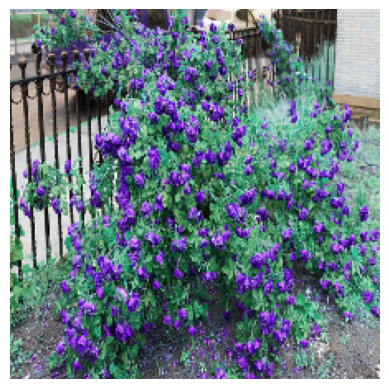

In [ ]:
plt.axis('off')
plt.imshow(X[0])

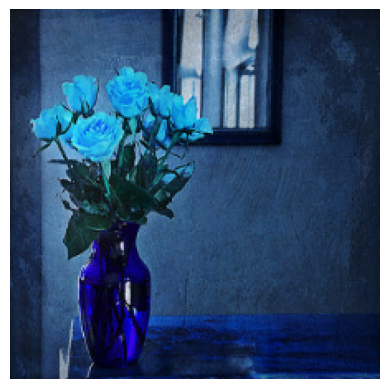

In [ ]:
plt.axis('off')
plt.imshow(X[1])

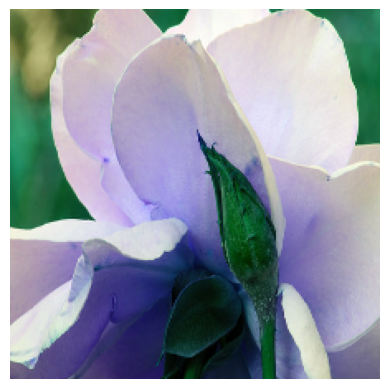

In [ ]:
plt.axis('off')
plt.imshow(X[2])

In [ ]:
X[0].shape

(224, 224, 3)

In [79]:
y_train

array([1, 1, 4, ..., 2, 4, 4])

In [84]:
224 * 224 * 3

150528

In [21]:
IMAGE_SHAPE = (224, 224)

model = keras.Sequential([
    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape=IMAGE_SHAPE+(3,)),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(500, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(250, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation = 'sigmoid')
])
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs = 5, validation_split = 0.1)

Epoch 1/5
67/67 [==============================] - 171s 3s/step - loss: 2.2248 - accuracy: 0.3718 - val_loss: 1.1611 - val_accuracy: 0.5336
Epoch 2/5
67/67 [==============================] - 170s 3s/step - loss: 1.1951 - accuracy: 0.4846 - val_loss: 1.0586 - val_accuracy: 0.6134
Epoch 3/5
67/67 [==============================] - 171s 3s/step - loss: 1.0509 - accuracy: 0.5753 - val_loss: 1.0233 - val_accuracy: 0.5714
Epoch 4/5
67/67 [==============================] - 167s 2s/step - loss: 0.7984 - accuracy: 0.6899 - val_loss: 1.0307 - val_accuracy: 0.5714
Epoch 5/5
67/67 [==============================] - 170s 3s/step - loss: 0.5057 - accuracy: 0.8045 - val_loss: 1.0535 - val_accuracy: 0.6345


In [22]:
scores = model.evaluate(X_test_scaled, y_test)

19/19 [==============================] - 10s 552ms/step - loss: 0.9858 - accuracy: 0.6353


In [23]:
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 63.53%


In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


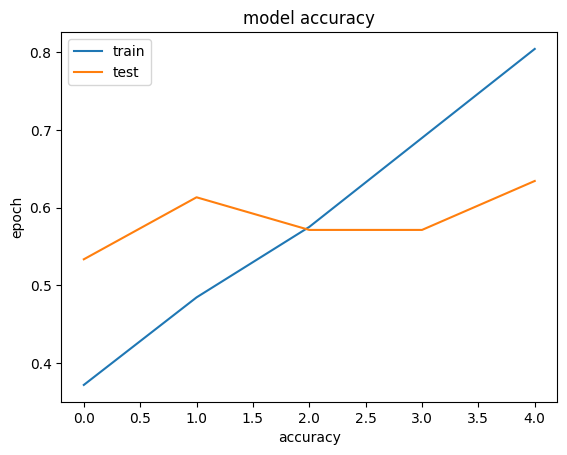

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

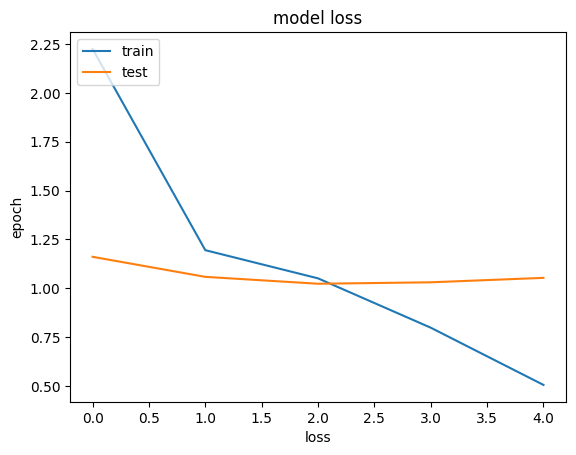

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [30]:
y_pred = model.predict(X_test_scaled)

19/19 [==============================] - 17s 865ms/step


In [34]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:10]

[2, 0, 1, 4, 1, 0, 0, 4, 0, 0]

In [33]:
y_test[:10]

array([2, 1, 0, 0, 1, 0, 0, 4, 0, 0])

In [48]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape = (224, 224, 3), trainable = False)

In [35]:
num_of_flowers = 5

transfer_model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers)
])
transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
transfer_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)
history_2 = transfer_model.fit(X_train_scaled, y_train,  epochs = 5, validation_split = 0.1)

Epoch 1/5
67/67 [==============================] - 65s 930ms/step - loss: 0.6852 - accuracy: 0.7381 - val_loss: 0.3763 - val_accuracy: 0.8529
Epoch 2/5
67/67 [==============================] - 54s 801ms/step - loss: 0.3376 - accuracy: 0.8789 - val_loss: 0.3240 - val_accuracy: 0.8613
Epoch 3/5
67/67 [==============================] - 54s 802ms/step - loss: 0.2613 - accuracy: 0.9121 - val_loss: 0.3096 - val_accuracy: 0.8697
Epoch 4/5
67/67 [==============================] - 53s 794ms/step - loss: 0.2173 - accuracy: 0.9331 - val_loss: 0.3028 - val_accuracy: 0.8824
Epoch 5/5
67/67 [==============================] - 52s 783ms/step - loss: 0.1899 - accuracy: 0.9425 - val_loss: 0.3051 - val_accuracy: 0.8697


In [49]:
transfer_scores = transfer_model.evaluate(X_test_scaled, y_test)

19/19 [==============================] - 13s 673ms/step - loss: 0.3144 - accuracy: 0.8807


In [50]:
print("\n%s: %.2f%%" % (transfer_model.metrics_names[1], transfer_scores[1]*100))


accuracy: 88.07%


In [51]:
print(history_2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


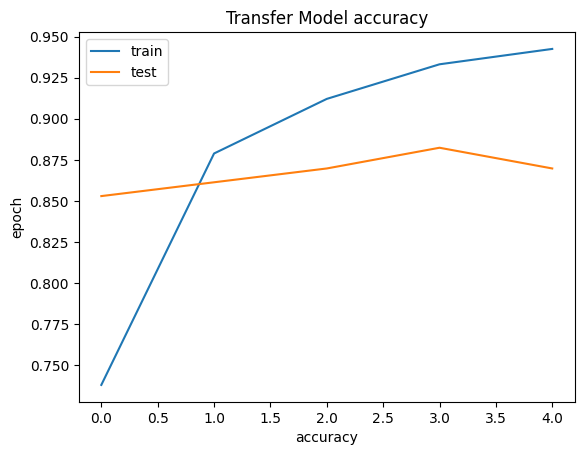

In [55]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Transfer Model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

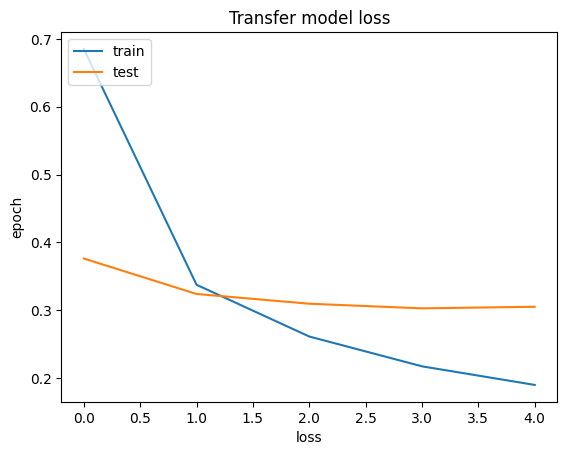

In [56]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Transfer model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show

In [57]:
y_p = transfer_model.predict(X_test)

19/19 [==============================] - 15s 790ms/step


In [60]:
y_classes = [np.argmax(element) for element in y_p]
y_classes[:5]

[1, 1, 1, 2, 1]

In [61]:
y_test[:5]

array([2, 1, 0, 0, 1])